## NASA Frontier Development Lab - Disaster Prevention, Progress and Response (Floods)

Floods are the most destructive and dangerous natural disasters worldwide. All regions can be affected by flooding events and, with the increased variability in weather patterns due to global warming, this is likely to become even more prelevant. The speed at which flooding events can occur, and difficulties in predicting their occurrance, create huge logistic problems for both governmental and non-governmental agencies. Over the past 10 years, floods have caused on average 95 deaths a year in the US alone, making them the deadliest weather related phenomenon. Worldwide, floods cost in excess of 40 Billion dollars per year, impacting property, agriculture and the health of individuals.

Throughout the duration of the project, we collaborated with United States Geological Survey (USGS), a scientific agency within the US Department of the Interior. The objective of this organization is to study the landscape of the US and provide information about its natural resources and the natural hazards that affect them. Currently, hydrologists use physical models to help predict floods. These models require predictions to be carefully calibrated for each stream or watershed and careful consideration must be taken for dams, levees etc. Producing these models is extremely costly due to resource requirements. This limits the areas within the US that can avail of such systems to better prepare for flood events.

To predict the flood susceptibility of a stream area, the project was separated into two distinct problems.

**Monthly Model**

Predicting, per month, if a stream height will reach a predefined flood threshold. These flood thresholds are set by the National Oceanic and Atmospheric Administration (NOAA) and were location specific. Knowing which areas are susceptible to flooding, allow locations to better prepare for a flood event.

**Time to Peak Model**

Predicting the time taken for a stream/river to reach it's peak height. Following a major rain event occurs, knowing how long it will take for a river to reach this height is vital in order to inform potentially affected individuals if and when they need to evacuate. This can help to reduce structural damage and loss of life during a disaster.

## The Data

This project focused on 6 states within the US, over a period of 10 years. Data was taken from ~800 gauge sites, between July 2009 and June 2019. Not all gauge sites had continuous historical data over the period, but all the available data for each site was used.

The 6 states were:

    -New Jersey
    -Nebraska
    -South Carolina
    -New York
    -South Dakota
    -Virginia
    
A primary reason for choosing these states, was that each exhibits similar climate and landscape. Focusing on similar geographies from a machine learning perspective ensures that the models produced could be generalized to similar regions and given assumed reduced variability in conditions, models that are more precise.

Other required datasets and providers:

**USGS**

This consists of the height of a stream as measured by gauges for over 11,000 sites in the US. The data is updated every 15 minutes, with some locations having historical data for over 50 years. 

**PRISM**

The PRISM Climate Group provides climate observations across the whole of the US. This dataset was used to extract daily precipitation readings from the site locations for each day during the requested 10 year period.

**National Land Cover Database (NLCD)**

The NLCD database was collected using Landsat. This provides information such as land-use classification (urban, agriculture, forest, etc.), how well the land allows water to pass through it (impervious surface information) and tree cover. This dataset has updated records every 5 years from 2006.

**National Hydrology Dataset Plus (NHDPlus)**

NHDPlus is a geo-spatial hydrologic framework dataset associated with USGS. The features used from this dataset were the catchment and drainage area characteristics at the stream site locations. 

**Flooded Locations And Simulated Hydrographs Project (FLASH)**

FLASH is a database containing information about flood events within the US. The information used from this dataset was the time taken for a river to reach its peak height after a major rain event.

**NOAA**

NOAA is a US governmental agency for monitoring and preserving the climate and environment. The data provided by NOAA surrounded flood level thresholds for locations across the US. These thresholds consisted of four warning stages and the river height for a given location that causes them to reach these levels. The four warning stages were:

|Warning |  Meaning                                                                                     |
|--------|-------                                                                                     |
|Action  |	Mitigation action needs to be taken in order to prepare for possible hydrological activity|
|Flood	 |  The river height poses a threat to lives, property and businesses|
|Moderate| 	Some inundation of roads or buildings. A flood warning should be released|
|Major	 |  Extensive inundation of roads and buildings. Considerable evacuations of areas may occur|


A more indepth discussion on these datasources can be found within the associated whitepaper.

### Downloading the data

As some of the required datasets are particularly large, they are not contained within data directory of this github repo. The README file associated with this notebook contains information explaining how to download all the required datasets.

## Load Required Libraries and Python Functionality

#### Relevant Python functionality were loaded


 - embedPy
 - data manipulation functions
 - plotting functionality
 - Scoring functionality and machine learning models

In [1]:
\l p.q

np:.p.import[`numpy]
gp :.p.import[`geopandas]
train_test_split:.p.import[`sklearn.model_selection]`:train_test_split

plt:.p.import[`matplotlib.pyplot]

precision_recall_curve :.p.import[`sklearn.metrics]`:precision_recall_curve
average_precision_score:.p.import[`sklearn.metrics]`:average_precision_score
RandomForestClassifier :.p.import[`sklearn.ensemble]`:RandomForestClassifier
XGBClassifier          :.p.import[`xgboost]`:XGBClassifier

#### Relevant libraries and scripts were loaded

 - Load the machine learning toolkit
 - Load flood data and associated code

In [2]:
\l ml/ml.q 
.ml.loadfile`:init.q

\l ../floods.q
.fld.loadfile`:init.q

## Data Preprocessing

Due to the variety of data sources and datasets used, preprocessing the data was of critical importance. This step ensured that feature engineering completed later in the pipeline was more seamless. 

In [3]:
// Utility functions

del:{![x;enlist (=;y;z);0b;`symbol$()]} / Functional delete
conv7_fn:{`$$[7=count x;"0",;]x}        / Prepend sites with 7 numbers with a 0

The following were the operations taken on the data at this stage:

1. Any stream-site names containing less than 8 values were prepended with 0's to ensure consist lengths
2. Rows containing nulls or infinities were removed from the datasets as these couldn't be passed to machine learning algorithms.
3. A column denoting the index of each location in the NOAA threshold dataset was added (used for nearest neighbours calculations)

In [4]:
precip:update conv7_fn each string each site_no from del[precipall;`ppt;0n]

maxht:update conv7_fn each site_no from del[max_ht_str;`height;neg[0w]]

warning:update nn:i from warnings

4. Site ids in the PRISM dataset were modified such that no site ids were the same and a limit of 12 digits for an individual site was adhered to. Manipulation of the PRISM dataset was more involved here. The steps taken were as follows with each step associated with an individual code block:

    - All sites from the gauges data with more than 12 digits were found
    - Sites in the PRISM data associated with this gauge dataset were located
    - Removal of trailing digits can cause clashes between the site_ids, in this data such a clash only occured at index 20 in the names table. The indexes in the dataset at which these clashes occured were found and split based on unique lat/long values.
    - Exception lists and new id lists were created in order to correctly process data
    - The precipitation table was updated based on the updates to id's and clashes

In [5]:
rms:asc ds where 12<count each ds:string exec distinct site_no from gauges 

names:0!select i by site_no from precip where site_no in `$12#'rms

matchnames:0!select i by lat,long from precip where i in names[`x][20]

lst1:til[26]except 21 22; lst2:til[25]except 20
i1:`$rms[lst1],rms[21 22]; i2:(names[`x]lst2),matchnames`x

precip:{![x;enlist(in;`i;z);0b;enlist[`site_no]!enlist enlist y]}/[precip;i1;i2]

5. A column was added, allowing the NLCD dataset which is updated every 5 years (2006,2011,2016) to be joined later on in the notebook. In order to join the correct NLCD dataset with the appropriate row in the precipitation dataset, an extra column was added indicating what year it should be joined to.

    - The precipitation dataset was binned into the years 2006, 2011, 2016 by creating an upper bound depending on the year that the row corresponds to. 
    - This column was then added to the dataset.

In [6]:
nlcdyear:{$[x<2011;6;x<2016;11;16]}each `year$precip[`date]

precip:update year:nlcdyear from precip

## Feature Engineering

Given the available data, it was possible to split the information into three datasets

1. Ungauged basin: Information available at sites that do not contain stream gauge or future forecasting information. Data was limited to land use, past rainfall and upstream information.


2. Gauged basin: All information contained within the ungauged basin dataset, as well as stream gauge information. This included previous river heights and lagged/aggregated flooding information.


3. Perfect Forecasts: All information contained within the gauged basin dataset, as well as precipitation information around the time of the event.

Within the feature engineering section of this notebook, the majority of the features which encorporate the set of the above datasets were produced, they were then split into appropriate datasets later in the notebook.

### Seasonality information and data restrictions

Seasonal Information plays an important role when predicting if an area will flood and how long it will take. 

 - This seasonality was captured by extracting the month that the event occured, followed by using sine and cosine transformations of the month, creating a `cos_t` and `sin_t` column. 
 - The latitude and longitude of the stream sites were also represented as sine and cosine decompositions of their x, y and z coordinates.

In [7]:
pi:acos -1

precip:`date xasc update month:`mm$date from precip
precip:update cos_t:cos 2*pi*month%12,sin_t:sin 2*pi*month%12 from precip

precip:update x:cos(lat)*cos(long),y:cos(lat)*sin(long),z:sin(lat) from precip

###  Upstream, previous, windowed, and lagged features

Some of the most important feature information which was extracted from the dataset include:

1. Upstream features (for example rainfall and stream/river height) which may provide early warnings for high volumes of water moving down-stream
2. Previous rainfall and stream/river height at a location up to a number of days before the event.
3. Windowed historical information which gives macro information about the system, this can include the maximum moving average rainfall in a location over a given time period for example .
4. Lagged features which provide historical information about the behaviour of the system (in this case an individual site).

For ease of implementation, the creation of these features within this white paper were wrapped within the macro function `feat`.

For clarity the following are the inputs to the functions `feat`:

**feat [x ; y ; z ; col ; d; fnc]**

- `x`    table that's being updated
- `y`    how many values to calculate (integer list)
- `z`    column to apply the function to (symbol)
- `col`  new column name (symbol)
- `d`    dictionary of where, groupby and type of functional statement being used
- `fnc`  function to be applied to the grouped column


In [8]:
colname:{enlist`$string[y],"_",string[x],"_",string[z]} // Create new column name
max_mavg:{(max;(mavg;y;x))}                             // Calculate maximal moving average
prv:{(xprev;y;x)}                                       // Calculate value of lagged features

// Applies functions to appropriate columns and rename columns appropriately
func:{[x;y;z;b]raze{[x;y;z;b]colname[x;y;z]!enlist b[x;z]}[z;y;;b]each raze x}

// upstream, previous, windowed and lagged extraction function
feat:{[x;y;z;col;d;fnc] d[`w][x;d`wh;d`gr;$[1<count[z];raze;]func[y;col;;fnc]each z]}

#### Upstream Values

Using the `feat` function, upstream information was obtained. This was possible as the id numbers for each site consist of the initial two digits which denote the basin catchment. The remaining digits are ascending values based on the location of gauges along the stream. A functional update was applied to the tables, grouping by basin catchments and date. This then enabled the upstream precipitation and height values to be extracted.

In [9]:
catch_site:((';#);2;($:;`site_no))           /Grouping site numbers by catchment, using the first 2 digits
site_date :`site_no`date!(catch_site;`date)
dict:`w`wh`gr!(!;();site_date)

upstr_ppt   :feat[precip;1;`ppt;`upstr;dict;prv]
upstr_height:feat[maxht;1;`height;`upstr;dict;prv]

#### Previous rainfall and stream height

The `feat` function was also used to find the rainfall and heights for both the current and upstream locations for each of the previous 10 days before an event. This was achieved by grouping the tables by site number, allowing the previous precipitation and height values to be obtained. 

In [10]:
dict[`gr]:site:(enlist `site_no)!enlist `site_no

prev_rain:feat[upstr_ppt;enlist 1_til 10;`ppt`upstr_ppt_1;`prev;sited:dict;prv]
all_height:feat[upstr_height;enlist 1_til 10;`height`upstr_height_1;`prev;dict;prv]

### Use-case specific features

All of the features calculated above are applicable in each use-case, however both the monthly and time-to-peak models also required more bespoke features to be calculated

### Monthly Model

The following steps were completed to extract additional features for the monthly model

1. The maximal moving average rainfall was extracted at current and previous upstream sites over different time windows following the date in question (1 - 15 day windows). This was achieved by initially grouping the data by month and site number, and then applying the `feat` function, denoting the size of the windows being applied

In [11]:
dict[`gr]:(`date`site_no)!(($;enlist`month;`date);`site_no)

all_rain:feat[prev_rain;enlist 1_til 15;`ppt`upstr_ppt_1;`window;dict;max_mavg]

2. The first day of each month was selected as the point of reference for the months data, allowing encompassing of information from the previous months information


In [12]:
height_data:update date:"m"$date from select from all_height where 1=`dd$date
rain_data  :update date:"m"$date from select from all_rain   where 1=`dd$date

3. The height and rain data were joined for each site and date to create the initial monthly dataset

In [13]:
monthly_data:height_data ij`site_no`date xkey rain_data

### Time to Peak Model

The hours leading to a flash flood event can provide important information regarding how quickly the height of a stream is moving. This information can be incredibly important in allowing for prediction of the time to reach its peak height.

For construction of the time to peak models the following steps were taken to produce appropriate features:

1. The FLASH dataset (`peak`) was joined to the daily height and rain datasets produced previously


In [14]:
peak_data:(peak ij`date`site_no xkey prev_rain)ij`date`site_no xkey all_height

2. The times in the FLASH dataset were converted from UTC such that they were consistent with the USGS stream data.

In [15]:
// The date associated with each site 
site_date:flip value flip 0!select date by distinct site_no from peak_data

// The timezone (unk) information for each site was obtained from the gauges hdb (str)
time_zone:raze{
  dd:x[1];si:x[0];
  select `$first site_no,`$first unk from str where date=first dd,si=`$site_no}each site_date

// The time-zone information was joined to the peak dataset
peak_data:peak_data ij`site_no xkey time_zone

// A function was defined to modify the time-zone based on extracted information from gauges hdb
change_zone:{tz:x[1];tm:x[0];$[tz=`EDT;tm-04:00;tz=`CDT;tm-05:00;tm-06:00]}

// The time zone change was applied to the relevant time columns in dataset
peak_data[`start_time]:change_zone each flip peak_data`start_time`unk
peak_data[`end_time]  :change_zone each flip peak_data`end_time`unk
peak_data[`peak_time] :change_zone each flip peak_data`peak_time`unk

3. The date column was updated where change from UTC resulted in a time in the previous day based on start time

In [16]:
peak_data[`date]:`date$peak_data`start_time

4. Maximal moving averages for windows of time up to 2 days prior to the event were extracted:

    - Functions to extract the appropriate date range to be extracted, the where clause to be applied, and a dictionary to be pased to the `feat` function were created 
    - Maximal moving average precipitation over 2, 4, 8, 12 and 48 hour windows were taken for the two days prior to the event.
    
    - The newly created features were included into the dataset and nulls and infinities were removed from the dataset

In [17]:
// The date range of interest 
range:{(within;x;(,;(+;(-:;2);y);y))}
// The where clause to be applied 
wh:{(range[`date;x[1]];range[`datetime;x[2]];(=;enlist x[0];($;enlist`;`site_no)))}
// Dictionary to be passed to the feat function
dict:{`w`wh`gr!(?;wh x;0b)}

wind_ht_prev:{feat[str;enlist 2 4 12 48;`height;`wind_prev;dict x;max_mavg]
  }each flip peak_data[`site_no`date`start_time]

peak_data:peak_data,'raze wind_ht_prev
peak_data:del[peak_data;`wind_prev_height_2;neg[0w]]

5. Extracted information relating to projected rainfall for the next 3 days:

    - A function defining the where clause was defined, along with the dictionary to be passed to the `feat` function.
    - Rainfall information for the 3 days following the evening of interest was then extrcated.
    - These extrac columns were added back into the dataset

In [18]:
wh:{((within;`date;(,;y[1];(+;y[1];x)));(=;enlist y[0];`site_no))}
dict:{`w`wh`gr!(?;wh[x;y];0b)}

rain_pred:{feat[all_rain;enlist 1_til x;`ppt`upstr_ppt_1;`fut_window;dict[x;y];max_mavg]
  }[3]each flip peak_data[`site_no`date]

peak_data:peak_data,'raze rain_pred

All the above extracted features were added to the respective datasets:


|Feature  |Associated Dataset |
|---------|-------------------|
|previous rainfall|ungauged, gauged, perfect forecasts|
|previous height|gauged, perfect forecasts|
|moving precip averages per month| perfect forecasts|
|previous windowed height| gauged,perfect forecasts|
|predicted precip rain for time to peak| perfect forecasts|


## Target Data

### Monthly Models

The target chosen for the monthly model task was extracted from the NOAA flood warning dataset. The target itself indicated if for a given month a flood stage warning was issued, thus the model required was a binary classifier. The flood warning level was one of 4 warning levels,

1. Action
2. Flood
3. Moderate
4. Major

In order to ensure that a sufficient number of positive targets were present in the data the flood level was chosen as moderate and major events are much rarer.

Given that the sites at which NOAA flood warnings are calculated and the location of gauge sites are not necessarily coincident, the latitude and longitude of the sites were used to complete a nearest neighbours join of the datasets, thus making a consistent dataset.

The steps taken to create the appropriate targets were as follows:

1. Nearest neighbours search was completed to map NOAA locations to stream sites based on latitude and longitude values :

    - A list `wlatl` was created, denoting the latitude and longitude of the NOAA warning locations and gauge sites
    - A kd-tree implementation was then created using the values from the `wlatl`, extracting the nearest neighbours of each gauge site
    - A keyed table was produced, indicating the nearest NOAA warning location to each gauge site


In [19]:
wlatl:raze each warning[`Latitude`Longitude],'gauges[`dec_lat_va`dec_long_va]

tabw:kd.buildtree[wlatl;2]
gauge_val:count[warning]+til count gauges
nnwarn:kd.nns[;tabw;(count[warning]#0),count[gauges]#1;flip wlatl;`edist]each gauge_val

joins:([site_no:gauges`site_no]nn:nnwarn[;0];ndw:nnwarn[;1])

2. The maximum height dataset `maxht` was joined to the flood warnings table. The flood warnings were then casted to floating points


In [20]:
floodlvl:(maxht ij joins)lj`nn xkey warning

floodlvl[`Action`Moderate`Flood`Major]:"F"$'floodlvl[`Action`Moderate`Flood`Major]

3. A table indicating how many times the stream has reached each level was created. Using the thresholds provided by NOAA and the stream gauge heights, the number of times per month that the designated threshold at a site was breached was counted.

In [21]:
10#threshold:0!select 
                first Action,first Flood,first Moderate,first Major,
                no_Action:count where height>Action,no_Flood:count where height>Flood,
                no_Mod:count where height>Moderate,no_Major:count where height>Major 
                by site_no,"m"$date from floodlvl

site_no  date    Action Flood Moderate Major no_Action no_Flood no_Mod no_Major
-------------------------------------------------------------------------------
01303500 2009.07 9.8    10.1  11.1     13.1  0         0        0      0       
01303500 2009.08 9.8    10.1  11.1     13.1  0         0        0      0       
01303500 2009.09 9.8    10.1  11.1     13.1  0         0        0      0       
01303500 2009.10 9.8    10.1  11.1     13.1  0         0        0      0       
01303500 2009.11 9.8    10.1  11.1     13.1  0         0        0      0       
01303500 2009.12 9.8    10.1  11.1     13.1  0         0        0      0       
01303500 2010.01 9.8    10.1  11.1     13.1  0         0        0      0       
01303500 2010.02 9.8    10.1  11.1     13.1  0         0        0      0       
01303500 2010.03 9.8    10.1  11.1     13.1  0         0        0      0       
01303500 2010.04 9.8    10.1  11.1     13.1  0         0        0      0       


4. Filter out any sites that indicate 28 days of flooding in a month due to a wish to prioritise irregular events
5. Create a binary classification target indicating if a flood warning level was reached


In [22]:
threshold:select from threshold where no_Flood<28

threshold[`target]:threshold[`no_Flood]>0

### Time to Peak Model

To produce a target for the time to peak model the FLASH dataset was used. This dataset provided information pertaining to how long it would take a gauge location to reach it's peak height after a rain event. To get this information and create a machine learning task the following steps were taken:

1. The start time of an event was subtracted from the peak time and converted to number of elapsed hours
2. A binary classification was created by setting if the peak height was reached in less than 3.5 hours after a major rainfall event. This time definition was set based on discussion with hydrologists at USGS.

In [23]:
peak_data[`delta_peak]:(peak_data[`peak_time]-peak_data[`start_time])*24

peak_data[`target]:peak_data[`delta_peak]<3.5

## Addition of final features

### Addition of the characteristics tables 

1. The basin characteristics and NLCD landcover datasets were then joined to create the `stream_char` table. This provided information on the geographical landscape of the site location. 

2. This table was then joined to the peak and monthly datasets based on site number to create `all_peak_data` and `all_monthly_data`.

3. The threshold information was also added to the monthly data by site number and date in order to allow for the addition of lagged information to be included in the next section.

In [24]:
stream_char:nlcd ij`site_no xkey basin

all_peak_data:peak_data ij`site_no`year xkey stream_char

all_monthly_data:(monthly_data ij`site_no`year xkey stream_char)ij`site_no`date xkey threshold

### Lagged features

For the monthly model, lagged features were added to the dataset:
 - The `feat` function was used to extract information pertaining to whether a specific site flooded in the last month or at that month one year prior. 
 - The number of times per month the flood warning level was reached at each site location was also extacted in the `tgts` table. 
 - This informatoin was then used to obtain the moving average for target data to create the `lagged_target_all` column

In [25]:
all_monthly_data:feat[all_monthly_data;enlist 1 12;`target;`lagged;sited;prv]

tgts:value exec no_Flood by site_no from all_monthly_data

all_monthly_data[`lagged_target_all]:raze{count[x]mavg raze x}each tgts

The above features were applicable to the gauged and perfect forecasts datasets

## Train-Test Split

### Preparation

Prior to the application of a train test split on the data, rows containing null information were removed from the dataset as these cannot be passed to machine learning algorithms. This was achieved by applying the `del_null` function to clean up the dataset.

In [26]:
del_null:{where not any each null x}

cleaned_monthly:all_monthly_data[del_null all_monthly_data]
cleaned_peak:   all_peak_data[del_null all_peak_data]

The appropriate feature columns for the monthly and time to peak models were extracted for each of the three separate datasets outlined earlier in the notebook:

1. Ungauged
2. Gauged
3. Perfect Forecasts


The feature columns to be included for each of these datasets mentioned earlier are mentioned in `columns_to_include.q` under the following headings:

1. ungauged_cols
2. gauged_cols
3. perfect_forecast_cols

These columns included the removal of any information which would be considered 'leakage' including target columns or any columns from which the target could be derived.

The columns for monthly (M) and time to peak (P) examples for each dataset were extracted using the `fnd_col` function as shown below.

In [27]:
fnd_col:{x where x in y}

ungauged_colsM:         fnd_col[ungauged_cols;cols cleaned_monthly]
gauged_colsM:           fnd_col[gauged_cols;cols cleaned_monthly]
perfect_forecast_colsM: fnd_col[perfect_forecast_cols;cols cleaned_monthly]

ungauged_colsP:         fnd_col[ungauged_cols;cols cleaned_peak]
gauged_colsP:           fnd_col[gauged_cols;cols cleaned_peak]
perfect_forecast_colsP: fnd_col[perfect_forecast_cols;cols cleaned_peak]

The following cell outlines the creation of a framework by which the appropriate datasets could be extracted for each of the monthly and time to peak tasks

1. Dictionaries containing the appropriate datasets for each task were defined
2. The function `split_dict` was created which takes a table and `M`/`P` as input and returns the appropriate data as a matrix

In [28]:
show ungauge: `M`P!(ungauged_colsM;ungauged_colsP)
gauge:   `M`P!(ungauge[`M],gauged_colsM;ungauge[`P],gauged_colsP)
forecast:`M`P!(gauge[`M],perfect_forecast_colsM;gauge[`P],perfect_forecast_colsP)

split_dict:{(!). flip(
  (`ungauged;flip x[ungauge[y]]);
  (`gauged;flip x[gauge[y]]);
  (`forecast;flip x[forecast[y]]))}

M| `month`cos_t`sin_t`elv`imp`CatAreaSqKm`WsAreaSqKm`CatAreaSqKmRp100`WsAreaS..
P| `month`cos_t`sin_t`elv`imp`CatAreaSqKm`WsAreaSqKm`CatAreaSqKmRp100`WsAreaS..


### Monthly Model

When splitting the data for this model, it was deemed important that no time leakage occurred between the training and test sets (e.g. the training set contained information from 2009 to 2017, while the test set contained the remaining years).

This ensured that the model was tested similarly to how it would be deployed in a real world scenario .i.e training on currently available information and testing on new information as it is available. 

The training set contained 80% of the data while the testing set contained the remaining 80%. The `split_dict` function defined previously is used to produce the training data

In [29]:
// The cutoff dataset was produced and date defined at which the datasets were cutoff
cutoff:update cutoff_date:min[date]+floor 0.8*max[date]-min[date] by site_no from cleaned_monthly

// Data and targets from the dataset were extracted
XtrainMi:select from cutoff where date<cutoff_date
ytrainM:exec target from cutoff where date<cutoff_date
XtestMi:select from cutoff where date>=cutoff_date
ytestM:exec target from cutoff where date>=cutoff_date

// From the master training and testing datasets the appropriate information for the monthly data was extracted
XtrainM:split_dict[XtrainMi;`M]
show XtestM:split_dict[XtestMi;`M]

ungauged| 6i  -1f          1.224647e-16  112f  14.68071    0.0522  20.4282  0..
gauged  | 6i  -1f          1.224647e-16  112f  14.68071    0.0522  20.4282  0..
forecast| 6i  -1f          1.224647e-16  112f  14.68071    0.0522  20.4282  0..


### Time to Peak Model

The following histogram displays sites which produced a flash flood event within the range of each bin. This highlighted the uneven distribution of targets across sites, thus explaining the need for a more complex data splitting methodology.

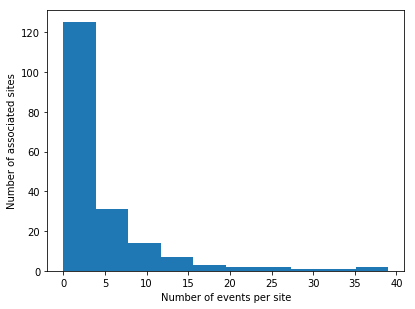

In [30]:
sites:0!select sum target by site_no from cleaned_peak
plt[`:hist][sites`target];
plt[`:xlabel]["Number of events per site"];
plt[`:ylabel]["Number of associated sites"];
plt[`:show][];

The splitting of this dataset was slightly more involved. In order to test generalization to new areas, the data was split such that sites could not appear in both the training and testing sets. In addition to this, given the uneven distribution of events in each site the data was stratified such that the training and testing sets contained sites which had similar levels of flood activity.

In [31]:
// The number of events associated with each bin of the dataset was set
bins:0 5 15 25.0

// The target data was split into their associated bins
y_binned:bins bin`float$sites`target

// Using embedPy, site numbers and targets were stratified into an 80-20 train-test split of the data
tts:train_test_split[sites[`site_no];sites[`target];`test_size pykw 0.2; `random_state pykw 607;
    `shuffle pykw 1b;`stratify pykw y_binned]`;

// The cleaned_peak data was updated such that a flag indicating training/testing set was denoted
cleaned_peak[`split]:`TRAIN
peak_split:update split:`TEST from cleaned_peak where site_no in`$tts[1]

As in the Monthly model, the split_dict function was used to appropriately split the dataset

In [32]:
XtrainPi:select from peak_split where split=`TRAIN
ytrainP:exec target from peak_split where split=`TRAIN
XtestPi:select from  peak_split where split=`TEST
ytestP:exec target from peak_split where split=`TEST

XtrainP:split_dict[XtrainPi;`P]
show XtestP:split_dict[XtestPi;`P]

ungauged| 7i  -0.8660254   -0.5          246f  12.16933   4.0455  47.2707  0...
gauged  | 7i  -0.8660254   -0.5          246f  12.16933   4.0455  47.2707  0...
forecast| 7i  -0.8660254   -0.5          246f  12.16933   4.0455  47.2707  0...


## Model Building and Evaluation

Thoughout the course of this work a wide variety of models were tested including Neural networks, however for the sake of this notebook, only models and results from an eXtreme Gradient Boost (XGBoost) and random forest classifier are presented below. These models were chosen due to their ability to deal with complex, imbalanced datasets. A more indepth discussion of these models can also be found in the associated whitepaper.

The following cell outlines a function used to fit both a Random-Forest classifier and XGBoost mode.This function returns a fitted model for each algorithm.

In [33]:
build_model:{[Xtrain;ytrain;dict]
 rf_hyp_nms:`n_estimators`random_state`class_weight;
 rf_hyp_vals:(dict`rf_n;0;(0 1)!(1;dict`rf_wgt));
 rf_clf:RandomForestClassifier[pykwargs rf_hyp_nms!rf_hyp_vals][`:fit][Xtrain; ytrain];

 xgb_hyp_nms:`n_estimators`learning_rate`random_state`scale_pos_weight`max_depth;
 xgb_hyp_vals:(dict`xgb_n;dict`xgb_lr;0;dict`xgb_wgt;dict`xgb_maxd);
 xgb_clf: XGBClassifier[pykwargs xgb_hyp_nms!xgb_hyp_vals][`:fit][np[`:array]Xtrain; ytrain];
 
 `random_forest`XGB!(rf_clf;xgb_clf)}

These models were used in the results section below in conjunction with the function `pr_curve` to test their performance on the training set. This function was used both to visulaize the results in the form of a precision-recall curve and also to provide important metrics

**pr_curve[ xtest ; ytest ; dict ]**

* xtest = matrix of feature values
* ytest = list of targets 
* dict  = dictionary of fitted models produced by build_model above

The output information from this function is as follows

1. Overall accuracy of the model 
2. Mean-Class accuracy which is a 'fairer' accuracy metric
3. Classification report outlining overall and class based precision, recall and f1-score
4. The precision-recall curves for each model and the area under the curve associated with each 

## Results

The scores and graphics in the results below were separated based on the three datasets created and sub divided into the monthly and time to peak models.

Following display of the graphics and scores, a summary of the results for each section was provided.

### Ungauged Prediction 

#### Monthly Model


Accuracy for random_forest: 0.9389502


Meanclass accuracy for random_forest: 0.8507405


class    | precision recall    f1_score  support
---------| -------------------------------------
0        | 0.9426159 0.9948198 0.9680145 13127  
1        | 0.7588652 0.2120912 0.3315259 1009   
avg/total| 0.8507405 0.6034555 0.6497702 14136  

Accuracy for XGB: 0.9214063


Meanclass accuracy for XGB: 0.6967247


class    | precision recall    f1_score  support
---------| -------------------------------------
0        | 0.9526141 0.9632818 0.9579183 13127  
1        | 0.4408353 0.3766105 0.4061999 1009   
avg/total| 0.6967247 0.6699461 0.6820591 14136  


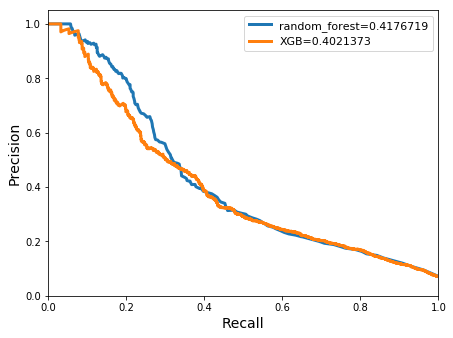

In [34]:
dict:`rf_n`rf_wgt`rf_maxd`xgb_n`xgb_lr`xgb_wgt`xgb_maxd!(200;1;8;200;.2;15;7)

models:build_model[XtrainM`ungauged;ytrainM;dict]

pltU1:pr_curve[XtestM`ungauged;ytestM;models]

#### Time to Peak Model


Accuracy for random_forest: 0.7509091


Meanclass accuracy for random_forest: 0.7635576


class    | precision recall    f1_score  support
---------| -------------------------------------
0        | 0.7474542 0.9657895 0.8427095 380    
1        | 0.779661  0.2705882 0.4017467 170    
avg/total| 0.7635576 0.6181889 0.6222281 550    

Accuracy for XGB: 0.7836364


Meanclass accuracy for XGB: 0.7564688


class    | precision recall    f1_score  support
---------| -------------------------------------
0        | 0.8056206 0.9052632 0.8525403 380    
1        | 0.7073171 0.5117647 0.5938567 170    
avg/total| 0.7564688 0.7085139 0.7231985 550    


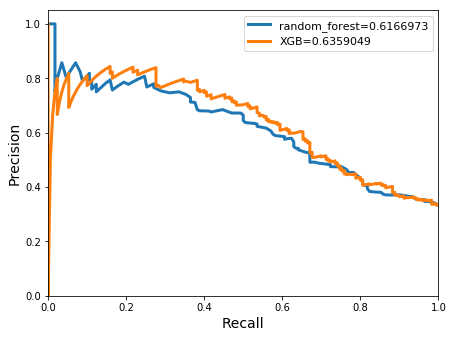

In [35]:
dict:`rf_n`rf_wgt`rf_maxd`xgb_n`xgb_lr`xgb_wgt`xgb_maxd!(220;1;17;340;.01;1.5;3)

models:build_model[XtrainP`ungauged;ytrainP;dict]

pltU2 :pr_curve[XtestP`ungauged;ytestP;models]

### Gauged Prediction

#### Monthly Model


Accuracy for random_forest: 0.942275


Meanclass accuracy for random_forest: 0.8926668


class    | precision recall    f1_score  support
---------| -------------------------------------
0        | 0.9443442 0.996572  0.9697554 13127  
1        | 0.8409894 0.2358771 0.3684211 1009   
avg/total| 0.8926668 0.6162245 0.6690882 14136  

Accuracy for XGB: 0.9333616


Meanclass accuracy for XGB: 0.749916


class    | precision recall    f1_score  support
---------| -------------------------------------
0        | 0.9551057 0.974023  0.9644716 13127  
1        | 0.5447263 0.4043608 0.4641638 1009   
avg/total| 0.749916  0.6891919 0.7143177 14136  


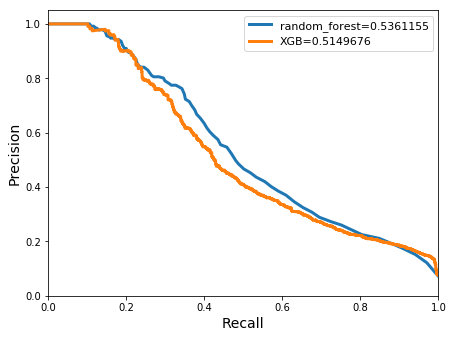

In [36]:
dict:`rf_n`rf_wgt`rf_maxd`xgb_n`xgb_lr`xgb_wgt`xgb_maxd!(100;16;8;100;0.2;16;9)

models:build_model[XtrainM`gauged;ytrainM;dict]

pltG1:pr_curve[XtestM`gauged;ytestM;models]

#### Time to Peak Model


Accuracy for random_forest: 0.7527273


Meanclass accuracy for random_forest: 0.7705355


class    | precision recall    f1_score  support
---------| -------------------------------------
0        | 0.7479675 0.9684211 0.8440367 380    
1        | 0.7931034 0.2705882 0.4035088 170    
avg/total| 0.7705355 0.6195046 0.6237727 550    

Accuracy for XGB: 0.7818182


Meanclass accuracy for XGB: 0.7575282


class    | precision recall    f1_score  support
---------| -------------------------------------
0        | 0.7995392 0.9131579 0.8525799 380    
1        | 0.7155172 0.4882353 0.5804196 170    
avg/total| 0.7575282 0.7006966 0.7164997 550    


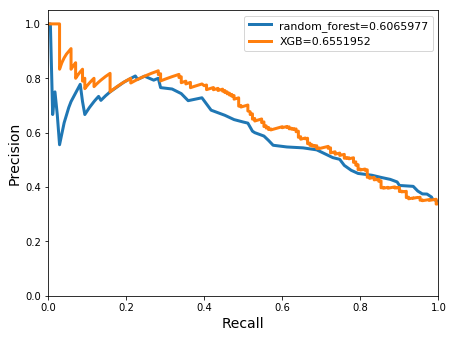

In [37]:
dict:`rf_n`rf_wgt`rf_maxd`xgb_n`xgb_lr`xgb_wgt`xgb_maxd!(100;1;17;350;0.01;1.5;3)

models:build_model[XtrainP`gauged;ytrainP;dict]

pltG2 :pr_curve[XtestP`gauged;ytestP;models]

### Perfect Forecast

#### Monthly Model


Accuracy for random_forest: 0.9459536


Meanclass accuracy for random_forest: 0.9156981


class    | precision recall    f1_score  support
---------| -------------------------------------
0        | 0.9473837 0.9971814 0.9716449 13127  
1        | 0.8840125 0.2794846 0.4246988 1009   
avg/total| 0.9156981 0.638333  0.6981718 14136  

Accuracy for XGB: 0.9451754


Meanclass accuracy for XGB: 0.7930223


class    | precision recall    f1_score  support
---------| -------------------------------------
0        | 0.97066   0.9702902 0.9704751 13127  
1        | 0.6153846 0.6184341 0.6169056 1009   
avg/total| 0.7930223 0.7943622 0.7936903 14136  


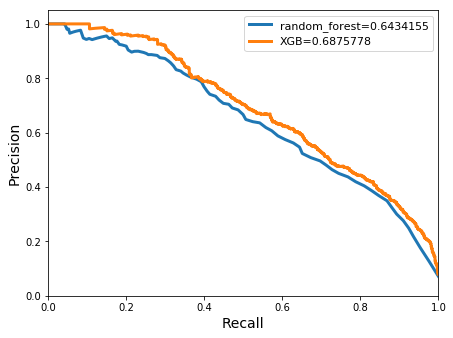

In [38]:
dict:`rf_n`rf_wgt`xgb_n`xgb_lr`xgb_wgt`xgb_maxd!(100;15;100;0.2;15;7)

models:build_model[XtrainM`forecast;ytrainM;dict]

pltP1:pr_curve[XtestM`forecast;ytestM;models]

#### Time to Peak Model


Accuracy for random_forest: 0.7454545


Meanclass accuracy for random_forest: 0.7553861


class    | precision recall    f1_score  support
---------| -------------------------------------
0        | 0.742915  0.9657895 0.8398169 380    
1        | 0.7678571 0.2529412 0.380531  170    
avg/total| 0.7553861 0.6093653 0.610174  550    

Accuracy for XGB: 0.7490909


Meanclass accuracy for XGB: 0.7057449


class    | precision recall    f1_score  support
---------| -------------------------------------
0        | 0.8151042 0.8236842 0.8193717 380    
1        | 0.5963855 0.5823529 0.5892857 170    
avg/total| 0.7057449 0.7030186 0.7043287 550    


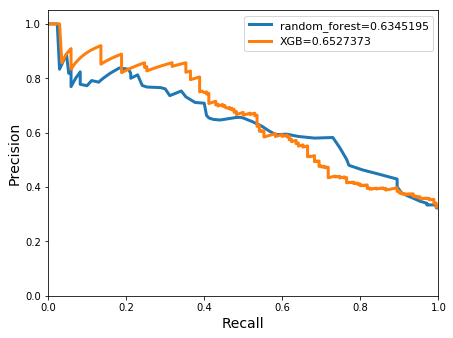

In [39]:
dict:`rf_n`rf_wgt`rf_maxd`xgb_n`xgb_lr`xgb_wgt`xgb_maxd!(100;1;17;300;0.01;2.5;3)

models:build_model[XtrainP`forecast;ytrainP;dict]

pltP2 :pr_curve[XtestP`forecast;ytestP;models]

### Scoring Summary

**Ungauged Models**

*Monthly*

The accuracy of both classifiers in the monthly model were relatively high, random forests achieving a slightly higher score of 0.9389502. The meanclass accuracy was lower in both classifiers, ranging from ~0.7-0.85 in the random forests and XGBoost respectively. However, considering that the class distribution was extremely inbalanced, the accuracy was not a good metric to measure by. Both classifiers returned low precision and recall scores when evaluating the positive class, indicating that the model was not very skilled at picking up on the flood events. Low scores of ~0.4 were also seen in the precision-recall curves for both classifiers.

*Time to Peak*

XGBoosts achieved both a higher accuracy of 0.78 and a more stable precision recall ratio, 0.7 to 0.51, for the positive class when compared with random forests, meaning that a relatively large amount of flood events occuring under the 3.5 hour threshold were being identified by the model. The meanlass accuracy for both classifiers were similar at ~0.76. The area under the precision-recall curve were comparable between both classifiers, with scores of 0.616 and 0.636 for the random forests and XGBoost being reached.

**Gauged Models**

*Monthly*

Improved accuracy and meanclass accuracy scores were evident in the gauged model, with higher accuracy again being achieved by the random forests. The meanclass acuracy also preformed relatively better at 0.89 when compared with the XGBoost classifier result of 0.75. Although still low, a slightly improved balance between the precision and recall scores, 0.5447 to 0.404, for the positve class was reached by the XGBoost. The area under the precision-recall curve improved in both classifiers to 0.51 (XGBoost) abd 0.53 (random forests) from the previous ungauged model.

*Time to Peak*

The accuracy and meanclass accuracy were extremely similar compared with the results obtained in the ungauged model. The precision and recall scores only slightly altered from the ungauged model. This indicated that the addition of previous stream/river heights did not impact the model. The areas under with the precision-recall curves however, were higher when compared with the previous models curves.

**Perfect Forecast Models**

*Monthly*

Similar accuracy results werew seen between the random forests and XGBoost with results of 0.945, with random forests achieving a greater meanclass accuracy score of 0.916 compared with that of XGBoosts 0.79. Precision and recall scores for the positive class were also high at 0.62 for both metrics, compared to the random forest classifier that produced an imbalanced precision score of 0.88 compared to 0.28 in the recall score. Both precision-recall curves improved from the previous gauged model, achieving areas of 0.69 and 0.64 for XGBoost and the random forest classifier respectively.

*Time to Peak*

A slight decrease in accuracy occured in both classifiers compared with previous models, although an improved  balance between the precision and recall scores of ~0.6 were seen for the XGBoost. The precision-recall curves slightly increased from the previous models results, reaching scores of 0.65 for the XGBoost and and 0.63 for the random forests classifiers.

### Feature Significance

There is also a lot to be learned from determining which features contribute to predicting the target for a model. As such analysis could allow decision makers to prioritise the information used to make decisions.

To find the features which were deemed statistically significant to prediction of the target, the function `ml.fresh.significantfeatures` from the machine learning toolkit was used. The top 15 features in both the monthly and time to peak models were found using `ml.fresh.ksigfeat[x]`.

The cell below defines some functionality used for the evaluation of both models:

In [40]:
title:{"The top 15 significant features for ",x," predictions are:"}
nums :{string[1+til x],'x#enlist". "}
kfeat:.ml.fresh.ksigfeat 15

#### Monthly Model

In [41]:
title["monthly"]
X_Month:flip forecast[`M]!cleaned_monthly[forecast[`M]]
y_Month:cleaned_monthly`target
3 cut`$nums[15],'string .ml.fresh.significantfeatures[X_Month;y_Month;kfeat]

"The top 15 significant features for monthly predictions are:"


1. lagged_target_all     2. window_ppt_1          3. window_ppt_2        
4. window_ppt_3          5. window_ppt_4          6. window_ppt_5        
7. window_ppt_6          8. window_upstr_ppt_1_1  9. window_upstr_ppt_1_2
10. window_upstr_ppt_1_3 11. window_upstr_ppt_1_4 12. lagged_target_1    
13. lagged_target_12     14. window_upstr_ppt_1_5 15. window_ppt_7       


#### Time to Peak Model

In [42]:
title["time-peak"]
X_t2p:flip forecast[`P]!cleaned_peak[forecast[`P]]
y_t2p:cleaned_peak`target
3 cut`$nums[15],'string .ml.fresh.significantfeatures[X_t2p;y_t2p;kfeat]

"The top 15 significant features for time-peak predictions are:"


1. WsAreaSqKmRp100       2. WsAreaSqKm          3. wind_prev_height_48
4. prev_upstr_height_1_1 5. wind_prev_height_12 6. prev_height_1      
7. prev_height_5         8. WetIndexCat         9. prev_height_4      
10. prev_height_7        11. prev_height_6      12. prev_height_2     
13. prev_height_8        14. wind_prev_height_4 15. prev_height_3     


## Graphics 

#### Monthly Model

Using these results, it was also possible to build a map highlighting which areas are at risk of flooding each month. This could be used by governmental bodies to prioritize funding in the coming weeks.

In [43]:
preds:last pltP1`model
newtst:update preds:preds from XtestMi
newt:select from newtst where date within 2018.01 2018.12m,preds=1
dfnew:.ml.tab2df newt
graphs:.p.get`AcledExplorer
graphs[`df pykw dfnew][`:render][];

**Note**

For clarity this uses a python function contained in the file `../code/graphics.p` from this directory. The use of interactive widgets in a JupyterQ through embedPy is limited in scope. More information and exmaples on using widgets in JupyterQ can be found on https://github.com/KxSystems/jupyterq/blob/master/examples/q_widgets.ipynb

#### Time to Peak Model

Given the information that has been extracted from above, a comparison between the predicted time that a stream will reach it's peak height was compared to the actual time of the peak height event. This is shown in the graphic below.

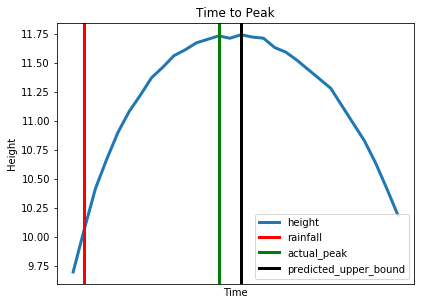

In [44]:
// The predictions for the ungauged model were extracted
pred:last pltU2`model

// For a specific site the start, peak and end times of an event were extracted
pg:raze select site_no,start_time,end_time,peak_time from XtrainPi 
    where unk=`EDT,i in where pred=XtestPi`target,site_no=`02164110,
    target=1,delta_peak>2

// The parameters used in plotting were defined
rainfall   :`x_val`col`title!(pg[`start_time];`r;`rainfall)
actual_peak:`x_val`col`title!(pg[`peak_time];`g;`actual_peak)
pred_bound :`x_val`col`title!(03:30+pg[`start_time];`black;`predicted_upper_bound)

// The relevant information for each site around the time of a major rainfall event was extracted
graph:select from str where date within (`date$pg[`start_time];`date$pg[`end_time]), datetime
      within (neg[00:15]+pg[`start_time];[00:10]+pg[`end_time]),(pg`site_no)=`$site_no

// The height was plotted as a function of time
times  :graph`datetime
heights:graph`height
plt_params:`label`linewidth!(`height;3)
plt[`:plot][times;heights;pykwargs plt_params];

// Lines indicating relevant events were plotted
pltline:{
  dict:`color`label`linewidth!(x`col;x`title;3);
  plt[`:axvline][x`x_val;pykwargs dict];}

pltline each(rainfall;actual_peak;pred_bound);

plt[`:legend][`loc pykw `best];
plt[`:title]["Time to Peak"];
plt[`:ylabel]["Height"];
plt[`:xlabel]["Time"];
plt[`:xticks][()];
plt[`:show][];

## Conclusion

From the above results we could predict, with relatively high accuracy, whether an area was likely to flood or not in the next month. We could also produce a model to predict if a stream would reach its peak height within 3.5 hours.

For the monthly models, the future weather predictions played an important role in predicting whether an area would flood or not. Accuracy increased as the weather predictions and gauged information columns were added to the dataset. This corresponded with the results from the significant feature tests, with lagged_target information and also the windowed rain values of the current month being the most important features to include. For the majority of the models, the random forests classifier obtained high accuracy results, but very unbalanced precision and recall scores. In some scenarios, high precision scores were achieved along with corresponding low recall, indicating that flooding events could be missed. Although XGBoosts didn't recieve as high accuracy, the precision and recall scores were much more balanced which is a favourable trait to have in this type of model when predicting an unpredictable event such as flooding. 

The opposite was true for the time-peak values, as previous rain and stream gauge information along with the basin characteristics were seen to be the most significant features when predicting these values. Including additional information about the future predicted rainfall did not improve the accuracy of the results, with the best results being obtained from the ungauged model by the XGBoost classifier. Despite this, the perfect forecasts dataset gave the most balance between the precision and recall of the positive class, compared with the ungauged model that favoured high precision alongside low recall scores. 

Both of these results are likely be physically expected. In the case of the monthly prediction, information regarding future forecast was pivotal in whether an area will flood in the next month. Whereas in the case of a time to peak value, it would be unlikely that information about rainfall in the next number of days would add to the predictive power of a model.

Knowing what features contribute to flood susceptibility and the length of time it takes for a river to reach its peak height, is an important piece of information to extract from the model. From this, organizations such as USGS can better prepare for flood events and understand how changing climates and placement of impervious surface can affect the likelihood of flooding.

The best results from the models above were obtained by continuously adjusting the hyper-parameters of the model. The unbalanced target data in the monthly model, meant that weighting the classes was an important feature to experiment with. This was particularly important when trying to obtain high precision and recall results. Between the two models, balance in the recall and precision was better for the XGBoost model.